In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

# Feature selection methods
from sklearn.feature_selection import (RFE, SelectKBest, f_classif, mutual_info_classif,SelectFromModel,VarianceThreshold)

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [3]:
# Load the wine dataset
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Features: {feature_names}")

Dataset shape: (178, 13)
Number of classes: 3
Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Define the number of features to select
n_features_to_select = 5

# Define feature selection methods
selection_methods = {
    "RFE": RFE(
        estimator=RandomForestClassifier(random_state=42),
        n_features_to_select=n_features_to_select,
        step=1
    ),
    "ANOVA F-value": SelectKBest(
        f_classif,
        k=n_features_to_select
    ),
    "Mutual Information": SelectKBest(
        mutual_info_classif,
        k=n_features_to_select
    ),
    "L1-based Selection": SelectFromModel(
        LogisticRegression(penalty="l1", solver="liblinear", C=0.1, random_state=42),
        max_features=n_features_to_select
    ),
    "Variance Threshold + KBest": Pipeline([
        ("variance", VarianceThreshold(threshold=0.1)),
        ("kbest", SelectKBest(f_classif, k=n_features_to_select))
    ])
}

# Define classifiers to test with
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

# Store results
results = pd.DataFrame(
    columns=["Feature Selection Method", "Classifier", "Selected Features", "Accuracy"]
)

In [7]:
# Run feature selection and classification
row = 0
for method_name, selector in selection_methods.items():
    # Apply selector
    selector.fit(X_train_scaled, y_train)
    
    # Transform data
    X_train_selected = selector.transform(X_train_scaled)
    X_test_selected = selector.transform(X_test_scaled)
    
    # Get selected feature names
    if hasattr(selector, "get_support"):
        selected_indices = selector.get_support(indices=True)
    elif hasattr(selector, "steps"):  # For Pipeline
        selected_indices = selector.steps[-1][1].get_support(indices=True)
    else:  # For SelectFromModel
        mask = selector.get_support()
        selected_indices = np.where(mask)[0]
        
    selected_features = [feature_names[i] for i in selected_indices]
    
    print(f"\n{method_name} selected features: {selected_features}")
    
    # Test with each classifier
    for clf_name, classifier in classifiers.items():
        # Train and evaluate
        classifier.fit(X_train_selected, y_train)
        y_pred = classifier.predict(X_test_selected)
        acc = accuracy_score(y_test, y_pred)
        
        # Store results
        results.loc[row] = [
            method_name,
            clf_name,
            ", ".join(selected_features),
            acc
        ]
        row += 1

print("\nFeature Selection Results:")
print(results[["Feature Selection Method", "Classifier", "Accuracy"]].round(4))


RFE selected features: ['alcohol', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']

ANOVA F-value selected features: ['alcohol', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']

Mutual Information selected features: ['flavanoids', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']

L1-based Selection selected features: ['alcohol', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']

Variance Threshold + KBest selected features: ['alcohol', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']

Feature Selection Results:
      Feature Selection Method           Classifier  Accuracy
0                          RFE  Logistic Regression    1.0000
1                          RFE        Random Forest    1.0000
2                          RFE                  SVM    1.0000
3                ANOVA F-value  Logistic Regression    1.0000
4                ANOVA F-value        Rando

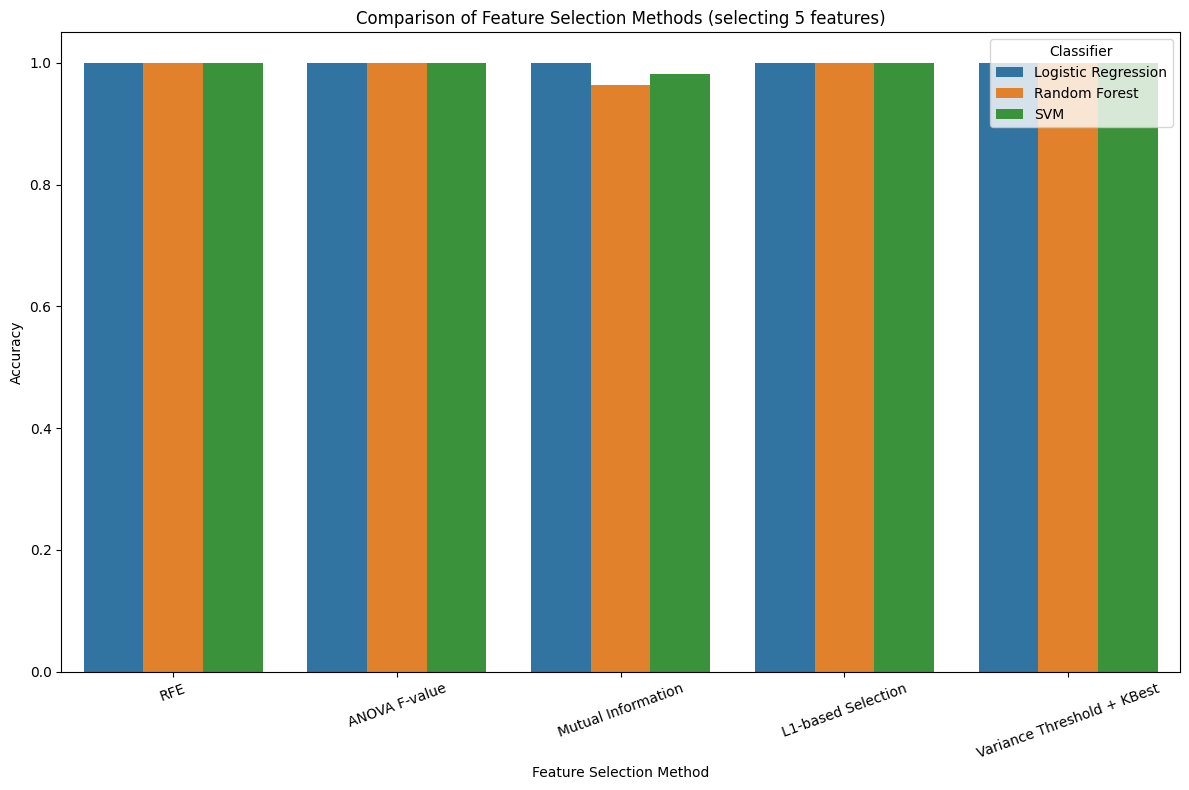

In [10]:
# Visualize results
plt.figure(figsize=(12, 8))
sns.barplot(x="Feature Selection Method", y="Accuracy", hue="Classifier", data=results)
plt.title(f"Comparison of Feature Selection Methods (selecting {n_features_to_select} features)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


Analyzing feature overlap between methods...


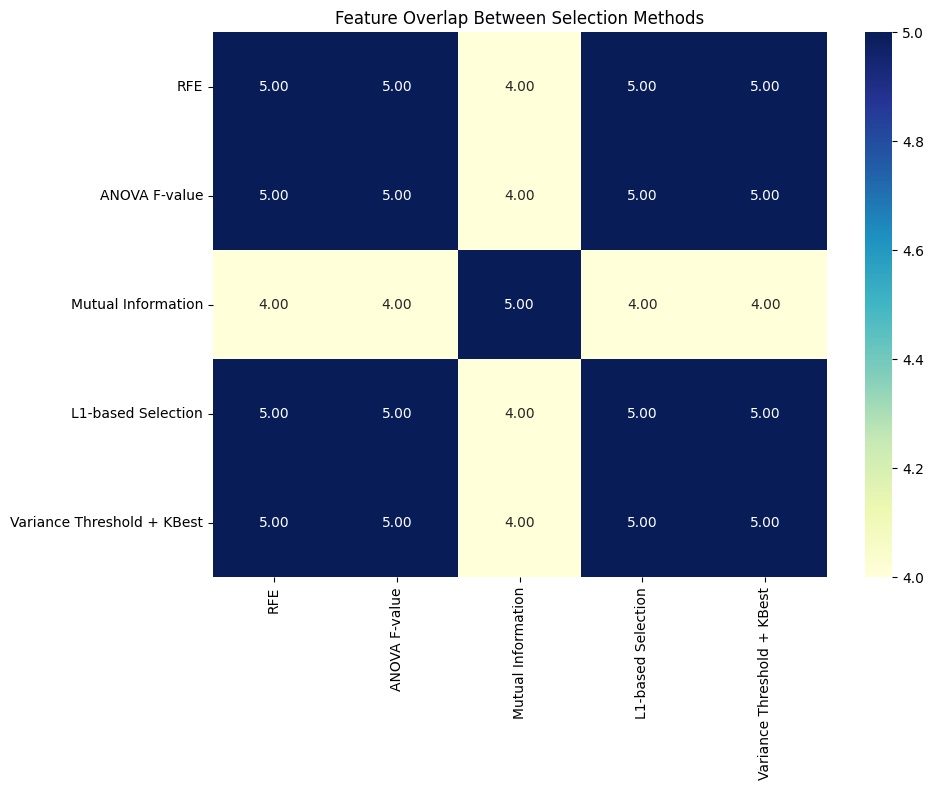

In [15]:
# Feature overlap analysis
print("\nAnalyzing feature overlap between methods...")

all_selected_features = {}
for method_name, selector in selection_methods.items():
    # Apply selector
    selector.fit(X_train_scaled, y_train)
    
    # Get selected feature names
    if hasattr(selector, "get_support"):
        selected_indices = selector.get_support(indices=True)
    elif hasattr(selector, "steps"):  # For Pipeline
        selected_indices = selector.steps[-1][1].get_support(indices=True)
    else:  # For SelectFromModel
        mask = selector.get_support()
        selected_indices = np.where(mask)[0]
        
    all_selected_features[method_name] = [feature_names[i] for i in selected_indices]

# Create overlap matrix
overlap_matrix = np.zeros((len(selection_methods), len(selection_methods)))
for i, (method1, features1) in enumerate(all_selected_features.items()):
    for j, (method2, features2) in enumerate(all_selected_features.items()):
        # Count common features
        common_features = set(features1).intersection(set(features2))
        overlap_matrix[i, j] = len(common_features)

# Visualize overlap
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, annot=True, fmt=".2f", 
            xticklabels=list(selection_methods.keys()),
            yticklabels=list(selection_methods.keys()),
            cmap="YlGnBu"
)
plt.title("Feature Overlap Between Selection Methods")
plt.tight_layout()
plt.show()

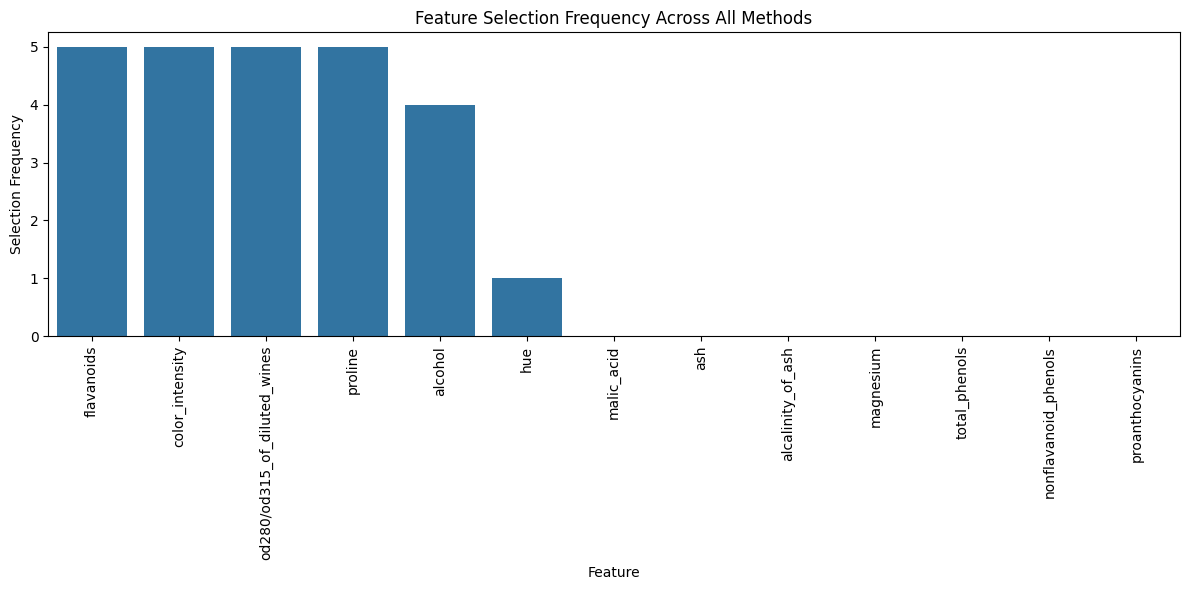

In [16]:
# Frequency of features being selected
feature_frequency = {feature: 0 for feature in feature_names}
for features in all_selected_features.values():
    for feature in features:
        feature_frequency[feature] += 1

feature_frequency_df = pd.DataFrame({
    'Feature': list(feature_frequency.keys()),
    'Selection Frequency': list(feature_frequency.values())
}).sort_values('Selection Frequency', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Selection Frequency', data=feature_frequency_df)
plt.title('Feature Selection Frequency Across All Methods')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [17]:
# Evaluate performance with cross-validation
print("\nEvaluating with cross-validation...")

cv_results = []
for method_name, selector in selection_methods.items():
    # Create pipeline with scaler, selector and classifier
    for clf_name, classifier in classifiers.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('selector', selector),
            ('classifier', classifier)
        ])
        
        # Perform cross-validation
        scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
        
        cv_results.append({
            'Feature Selection': method_name,
            'Classifier': clf_name,
            'Mean CV Accuracy': scores.mean(),
            'Std CV Accuracy': scores.std()
        })

cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df.round(4))


Evaluating with cross-validation...
             Feature Selection  ... Std CV Accuracy
0                          RFE  ...          0.0332
1                          RFE  ...          0.0323
2                          RFE  ...          0.0176
3                ANOVA F-value  ...          0.0408
4                ANOVA F-value  ...          0.0321
5                ANOVA F-value  ...          0.0110
6           Mutual Information  ...          0.0376
7           Mutual Information  ...          0.0323
8           Mutual Information  ...          0.0176
9           L1-based Selection  ...          0.0376
10          L1-based Selection  ...          0.0283
11          L1-based Selection  ...          0.0176
12  Variance Threshold + KBest  ...          0.0408
13  Variance Threshold + KBest  ...          0.0321
14  Variance Threshold + KBest  ...          0.0110

[15 rows x 4 columns]


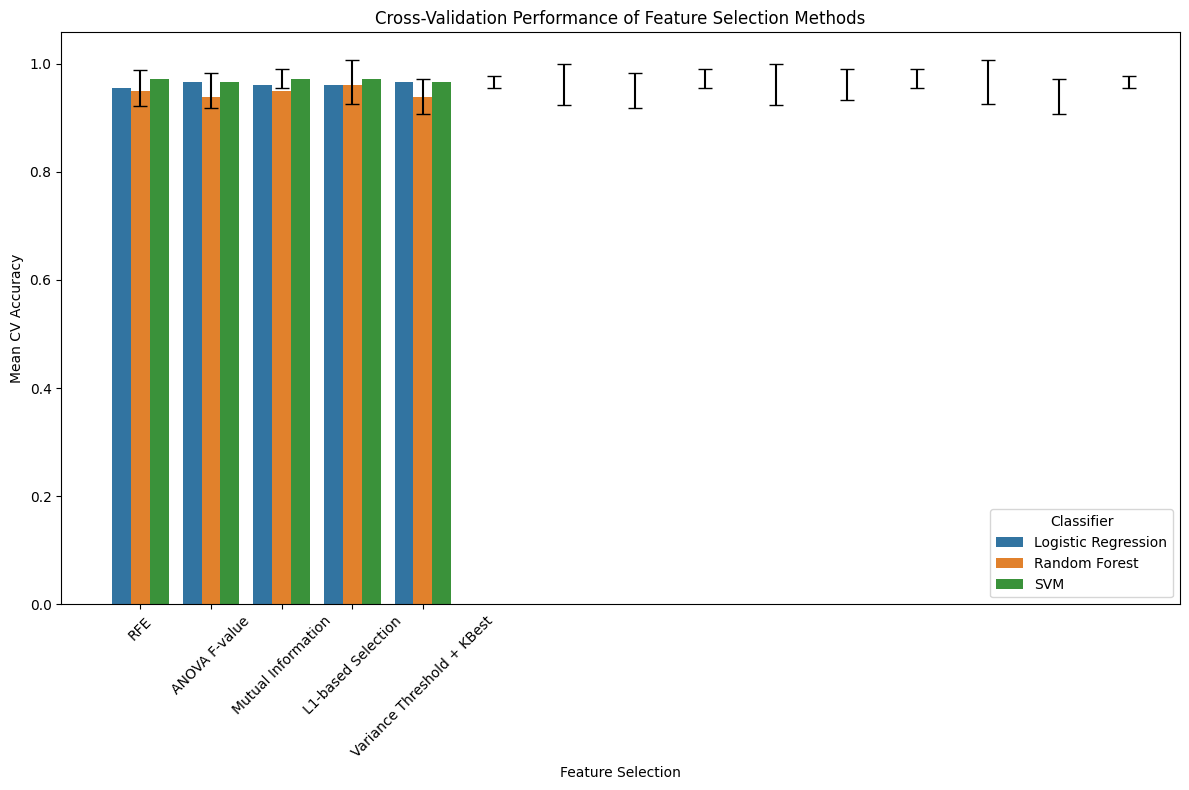

In [18]:
# Visualize cross-validation results
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Feature Selection', 
    y='Mean CV Accuracy', 
    hue='Classifier', 
    data=cv_results_df
)

plt.title('Cross-Validation Performance of Feature Selection Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.errorbar(
    x=np.arange(len(cv_results_df)), 
    y=cv_results_df['Mean CV Accuracy'],
    yerr=cv_results_df['Std CV Accuracy'],
    fmt='none', 
    c='black', 
    capsize=5
)

plt.show()

In [19]:
# Stability analysis
print("\nStability analysis of feature selection methods...")

# Function to evaluate stability by running selection on different data subsets
def evaluate_stability(selector, X, y, n_iterations=10, test_size=0.3):
    all_features = []
    
    for i in range(n_iterations):
        # Split data in a different way each time
        X_train, _, y_train, _ = train_test_split(X, y, test_size=test_size, random_state=i)
        
        # Scale data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        # Apply selector
        selector.fit(X_train_scaled, y_train)
        
        # Get selected features
        if hasattr(selector, "get_support"):
            selected_indices = selector.get_support(indices=True)
        elif hasattr(selector, "steps"):  # For Pipeline
            selected_indices = selector.steps[-1][1].get_support(indices=True)
        else:  # For SelectFromModel
            mask = selector.get_support()
            selected_indices = np.where(mask)[0]
            
        selected_features = [feature_names[i] for i in selected_indices]
        all_features.append(selected_features)
    
    # Calculate stability (Jaccard similarity)
    stability_scores = []
    for i in range(n_iterations):
        for j in range(i+1, n_iterations):
            intersection = len(set(all_features[i]) & set(all_features[j]))
            union = len(set(all_features[i]) | set(all_features[j]))
            jaccard = intersection / union if union > 0 else 0
            stability_scores.append(jaccard)
    
    return np.mean(stability_scores), all_features

# Evaluate stability of each method
stability_results = []

for method_name, selector in selection_methods.items():
    stability, selected_features_sets = evaluate_stability(selector, X, y)
    
    # Calculate feature selection probabilities
    feature_counts = {feature: 0 for feature in feature_names}
    for feature_set in selected_features_sets:
        for feature in feature_set:
            feature_counts[feature] += 1
    
    feature_probs = {feature: count / len(selected_features_sets) 
                    for feature, count in feature_counts.items()}
    
    # Get top features
    top_features = sorted(feature_probs.items(), key=lambda x: x[1], reverse=True)
    top_features = [f"{f}({p:.1f})" for f, p in top_features if p > 0]
    
    stability_results.append({
        'Method': method_name,
        'Stability': stability,
        'Top Features': ", ".join(top_features[:5])
    })

stability_df = pd.DataFrame(stability_results)
print(stability_df[['Method', 'Stability']].round(4))


Stability analysis of feature selection methods...
                       Method  Stability
0                         RFE     0.8000
1               ANOVA F-value     0.8741
2          Mutual Information     0.7683
3          L1-based Selection     0.8000
4  Variance Threshold + KBest     0.8741


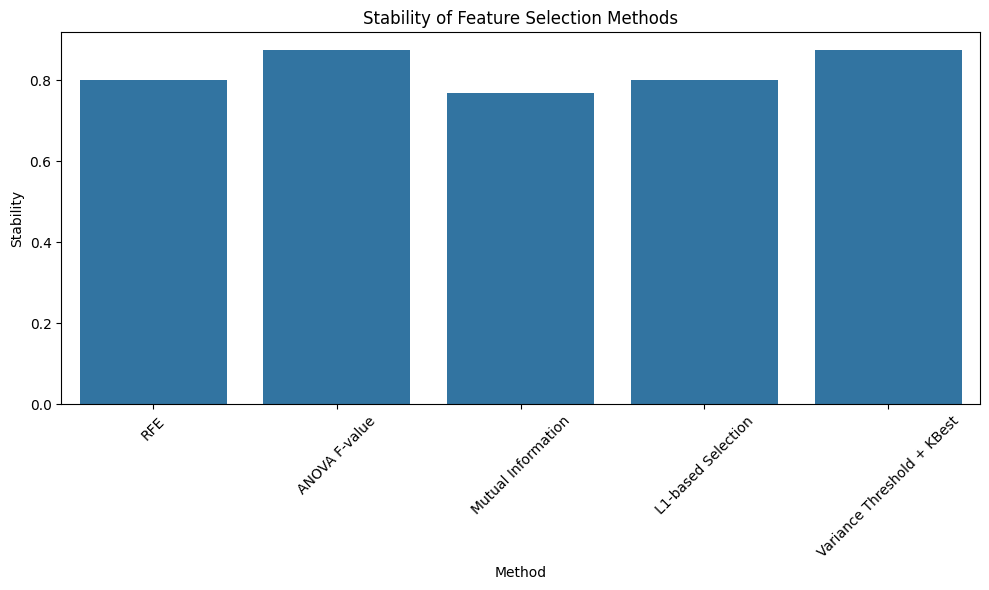

In [20]:
# Visualize stability
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Stability', data=stability_df)
plt.title('Stability of Feature Selection Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Final analysis and recommendations:


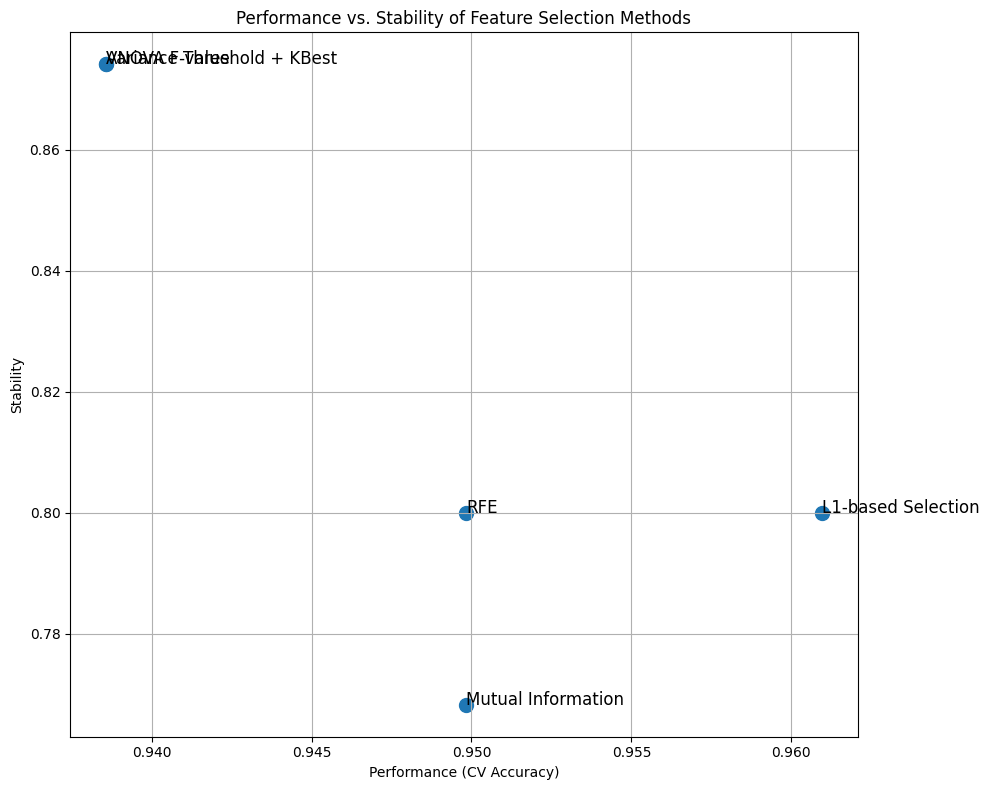

In [21]:
# Final comparison and recommendations
print("\nFinal analysis and recommendations:")

# Combine performance and stability
final_analysis = pd.merge(
    cv_results_df[cv_results_df['Classifier'] == 'Random Forest'][['Feature Selection', 'Mean CV Accuracy']],
    stability_df[['Method', 'Stability']],
    left_on='Feature Selection',
    right_on='Method'
)

# Plot performance vs stability
plt.figure(figsize=(10, 8))
plt.scatter(final_analysis['Mean CV Accuracy'], final_analysis['Stability'], s=100)

for i, method in enumerate(final_analysis['Method']):
    plt.annotate(
        method, 
        (final_analysis['Mean CV Accuracy'].iloc[i], final_analysis['Stability'].iloc[i]),
        fontsize=12
    )
    
plt.xlabel('Performance (CV Accuracy)')
plt.ylabel('Stability')
plt.title('Performance vs. Stability of Feature Selection Methods')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Print recommendations
print("\nRecommendations based on performance and stability:")

# Find best methods
best_performance_method = final_analysis.loc[final_analysis['Mean CV Accuracy'].idxmax(), 'Method']
best_stability_method = final_analysis.loc[final_analysis['Stability'].idxmax(), 'Method']

# Calculate combined score (you can adjust weights based on priorities)
final_analysis['Combined Score'] = 0.7 * final_analysis['Mean CV Accuracy'] + 0.3 * final_analysis['Stability']
best_overall_method = final_analysis.loc[final_analysis['Combined Score'].idxmax(), 'Method']

print(f"Best method for performance: {best_performance_method}")
print(f"Best method for stability: {best_stability_method}")
print(f"Best overall method (70% performance, 30% stability): {best_overall_method}")

# Show the final selected features from the best overall method
best_method = selection_methods[best_overall_method]
best_method.fit(X_train_scaled, y_train)

if hasattr(best_method, "get_support"):
    selected_indices = best_method.get_support(indices=True)
elif hasattr(best_method, "steps"):  # For Pipeline
    selected_indices = best_method.steps[-1][1].get_support(indices=True)
else:  # For SelectFromModel
    mask = best_method.get_support()
    selected_indices = np.where(mask)[0]
    
best_features = [feature_names[i] for i in selected_indices]
print(f"\nRecommended features from {best_overall_method}: {best_features}")


Recommendations based on performance and stability:
Best method for performance: L1-based Selection
Best method for stability: ANOVA F-value
Best overall method (70% performance, 30% stability): ANOVA F-value

Recommended features from ANOVA F-value: ['alcohol', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']
